In [1]:
using Distributions
using Rocket
using ReactiveMP
using BenchmarkTools
using Plots

import Base: show

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1260
┌ Warning: Package ReactiveMP does not have Rocket in its dependencies:
│ - If you have ReactiveMP checked out for development and have
│   added Rocket as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ReactiveMP
└ Loading Rocket into ReactiveMP from project dependency, future warnings for ReactiveMP are suppressed.


In [2]:
function hgf(n, iters, data)
    model = Model(DefaultMessageGate())
    
    xt_min = add!(model, datavar(:xt_min, NormalMeanVariance{Float64}))
    xt     = add!(model, simplerandomvar(:xt))
    
    zt = add!(model, datavar(:zt, NormalMeanVariance{Float64}))
    kt = add!(model, datavar(:kt, NormalMeanVariance{Float64}))
    ωt = add!(model, datavar(:kt, NormalMeanVariance{Float64}))
    
    gcv = add!(model, GCVNode())
    
    connect!(gcv, :x, xt_min, 1)
    connect!(gcv, :y, xt, 1)
    connect!(gcv, :z, zt, 1)
    connect!(gcv, :κ, kt, 1)
    connect!(gcv, :ω, ωt, 1)
    
    add_noise = add!(model, AdditionNode())
    noise     = add!(model, constvar(:noise, Normal(0.0, sqrt(200.0))))
    
    connect!(add_noise, :in1, xt, 2)
    connect!(add_noise, :in2, noise, 1)
    
    y = add!(model, datavar(:y, Float64))
    
    connect!(add_noise, :out, y, 1)
    
    activate!(model, gcv)
    activate!(model, add_noise)
    
    # Linking
    link(zt, getmarginal(zt))
    link(kt, getmarginal(kt))
    link(ωt, getmarginal(ωt))
    
    # Initial messages
    # update!(zt, NormalMeanVariance(0.0, 10000.0))
    # update!(kt, NormalMeanVariance(0.0, 10000.0))
    # update!(ωt, NormalMeanVariance(0.0, 10000.0))
    
    # Prior marginals
    # setmarginal!(gcv, :xy, MvNormal()) ?
    setmarginal!(gcv, :z, NormalMeanVariance(0.0, 10000.0))
    setmarginal!(gcv, :κ, NormalMeanVariance(0.0, 10000.0))
    setmarginal!(gcv, :ω, NormalMeanVariance(0.0, 10000.0))

    link(xt_min, getmarginal(xt))
    
    # update!(xt_min, NormalMeanVariance(0.0, 10000.0))
    
    marginals = Vector{GaussianMeanVariance}(undef, n)
    
    subscribe!(getmarginal(x) |> enumerate(), (t) -> marginals[t[1]] = getdata(t[2]))
    
    for i in 1:n
        update!(y, data[i])
    end
    
    return marginals
end

hgf (generic function with 1 method)

In [17]:
n = 100
iters = 1

real_k = 3.0
real_w = -4.0

z_mean     = 25.0
z_variance = 1.0

obs_noise = 200.0

z = rand(Normal(z_mean, sqrt(z_variance)), (n,))
v = map(d -> real_k * d + real_w, z)
y = Vector{Float64}(undef, n)

y_prev = 0.0

for i in 1:n
    y[i] = rand(Normal(y_prev, v[i]))
    y_prev = y[i]
end

data = map(d -> d + rand(Normal(0, sqrt(obs_noise))), y);

In [18]:
@time marginals = hgf(n, iters, data);

ErrorException: Unsupported cluster size: 2

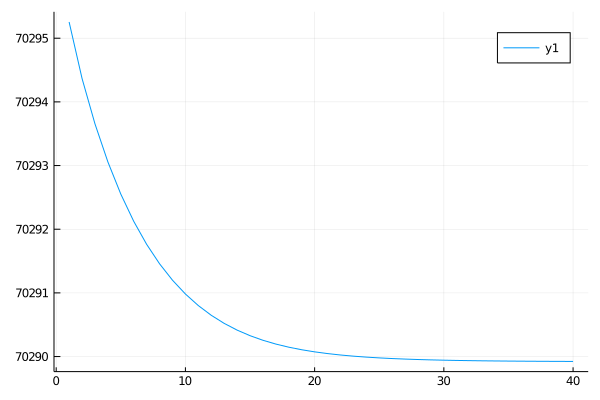

In [25]:
fevalues = vec(sum(fe, dims = 1))
plot(fevalues)

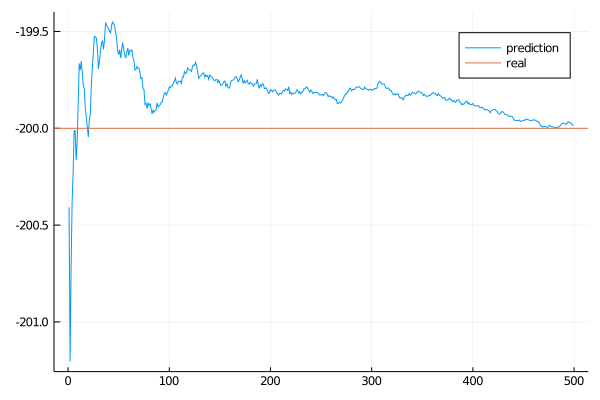

In [26]:
plot(ma[2:end], label = :prediction)
plot!([ realmean ], seriestype=:hline, label = :real)

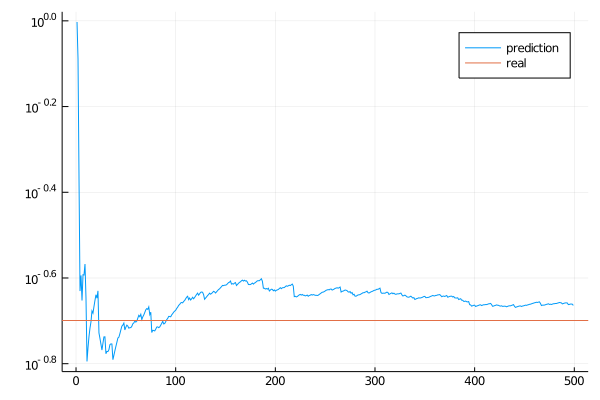

In [27]:
plot(pa[2:end], label = :prediction, yscale = :log10)
plot!([ realprecision ], seriestype=:hline, label = :real)

In [11]:
r = MvNormal([ 0.0, 0.0 ], [ 2.0 0.0; 0.0 1.0 ])

FullNormal(
dim: 2
μ: [0.0, 0.0]
Σ: [2.0 0.0; 0.0 1.0]
)


In [14]:
cov(r)

2×2 Array{Float64,2}:
 2.0  0.0
 0.0  1.0

In [15]:
?MvNormal

search: MvNormal MvNormalCanon MvNormalKnownCov MvLogNormal AbstractMvNormal



```
MvNormal
```

Generally, users don't have to worry about these internal details. We provide a common constructor `MvNormal`, which will construct a distribution of appropriate type depending on the input arguments.

```
MvNormal(sig)
```

Construct a multivariate normal distribution with zero mean and covariance represented by `sig`.

```
MvNormal(mu, sig)
```

Construct a multivariate normal distribution with mean `mu` and covariance represented by `sig`.

```
MvNormal(d, sig)
```

Construct a multivariate normal distribution of dimension `d`, with zero mean, and an isotropic covariance matrix corresponding `abs2(sig)*I`.

# Arguments

  * `mu::Vector{T<:Real}`: The mean vector.
  * `d::Real`: dimension of distribution.
  * `sig`: The covariance, which can in of either of the following forms (with `T<:Real`):

    1. subtype of `AbstractPDMat`,
    2. symmetric matrix of type `Matrix{T}`,
    3. vector of type `Vector{T}`: indicating a diagonal covariance as `diagm(abs2(sig))`,
    4. real-valued number: indicating an isotropic covariance matrix corresponding `abs2(sig) * I`.

**Note:** The constructor will choose an appropriate covariance form internally, so that special structure of the covariance can be exploited.
